RELATÓRIO SOBRE MODELAGEM DA ONDA ACÚSTICA

1. Introdução

O objetivo deste trabalho é simular parâmetros de aquisição sísmica real, construindo a geometria de aquisição a partir da disposição espacial de fontes e receptores. A modelagem computacional foi desenvolvida com base no método das diferenças finitas de quarta e oitava ordem, aplicado à resolução da equação da onda acústica em duas dimensões.

Foram utilizados dois modelos de velocidade para os testes: um modelo sintético composto por três camadas com velocidades distintas e o modelo Marmousi, amplamente empregado em estudos sísmicos por sua complexidade geológica. Para melhorar o desempenho computacional, a biblioteca Numba foi integrada ao código Python, possibilitando processamento paralelo eficiente. Além disso, foi incorporada uma máscara de atenuação nas bordas, conforme proposto por Cerjan, com o objetivo de minimizar reflexões artificiais nas bordas do modelo e assim aproximar a simulação de um cenário mais realista.

Com esses aprimoramentos, realizamos uma comparação direta entre os sismogramas obtidos numericamente e aqueles previstos por soluções analíticas.

Complementarmente, foi realizada uma simulação sísmica em um meio anisotrópico do tipo VTI (Vertical Transversely Isotropic), no qual as propriedades elásticas exibem simetria axial em relação à direção vertical. O objetivo principal desta modelagem foi avaliar numericamente a propagação da frente de onda em meio VTI e compará-la com soluções analíticas baseadas nas aproximações de anisotropia elíptica e fraca, segundo os parâmetros de Thomsen.

As frentes de onda analíticas foram sobrepostas aos snapshots gerados numericamente, permitindo uma análise qualitativa da aderência entre os modelos. Por meio dessa abordagem integrada, é possível validar a implementação do código em diferentes níveis de complexidade, analisar os efeitos da anisotropia nos tempos de trânsito das ondas, e verificar a consistência entre a resposta numérica e as soluções teóricas.

Parâmetros iniciais

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import jit
import pandas as pd
    

def ondas(nx,nz):
    u_anterior = np.zeros((nz,nx))
    u = np.zeros((nz,nx))
    u_posterior = np.zeros((nz,nx))
    return u_anterior, u, u_posterior
       
receiverTable = pd.read_csv("D:/GitHub/ModelagemSismica/inputs/receivers.csv")
sourceTable = pd.read_csv("D:/GitHub/ModelagemSismica/inputs/sources.csv")
rec_x = receiverTable['coordx'].to_numpy()
rec_z = receiverTable['coordz'].to_numpy()
shot_x = sourceTable['coordx'].to_numpy()
shot_z = sourceTable['coordz'].to_numpy()

T = 2 
dt = 0.0005

L = 5000
H = 5000
dx = 10
dz = 10
N = 100

nx = int(L/dx) + 1
nz = int(H/dz) + 1
nt = int(T/dt) + 1

nx_abc = nx + 2*N
nz_abc = nz + 2*N

rec_x = np.round(rec_x/dx).astype(int) + N 
rec_z = np.round(rec_z/dz).astype(int) + N
shot_x = np.round(shot_x/dx).astype(int) + N
shot_z = np.round(shot_z/dz).astype(int) + N

t = np.linspace(0, T, nt, endpoint=False)


2. Parâmetros de aquisição

2.1 Receptores e Fontes

Para levantamentos sísmicos são pré estabelecidos posições para os tiros e receptores, estes arranjos são utilizados para mapear as respostas a propagação das perturbações causadas pelas fontes sísmicas, que serão captadas pelos receptores. O arranjo escolhido foram receptores ao longo da superfície, um a cada dez metros ao longo da distância total de cinco quilômetros; para a fonte foi posicionada uma, no quilômetro dois mil e quinhentos. A função fonte adotada é a segunda derivada de uma Gaussiana que podemos controlar a frequência de corte contida no sinal.

2.2 Modelo de velocidade 

O modelo sintético foi construido a partir de duas velocidades, v1 = 3000, v2 = 4000 e separadas igualmente ao longo da profundidade de cinco quilômetros. Outro modelo utilizado foi o modelo Marmousi, desenvolvida pelo Institut Français du Petrole, com base em uma seção na Bacia do Cuanza.



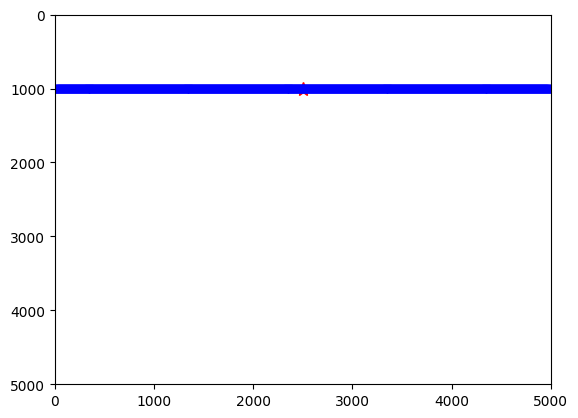

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# sources
sx_init = 2500
sx_end  = 4000
Nsource = 1
sx = np.linspace(sx_init,sx_end,Nsource)
sz = 1000*np.ones(len(sx))
sIdx = np.arange(Nsource)

# receivers
rx_init = 0
rx_end = 5001
Nrec = 501
rx = np.linspace(rx_init,rx_end,Nrec,endpoint=False)
rz = 1000*np.ones(len(rx))
rIdx = np.arange(Nrec)

plt.figure()
plt.plot(sx,sz,"r*", markersize = 10)
plt.plot(rx,rz,'bv')
plt.xlim(0,rx_end)
plt.ylim(rx_end,0)
plt.show()

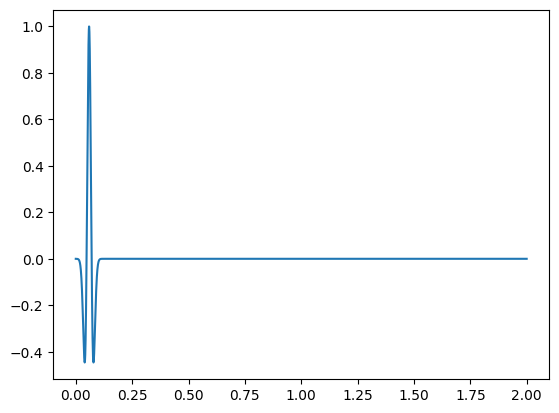

In [44]:
def ricker(f0, t):
    pi = np.pi
    td  = t - 2 * np.sqrt(pi) / f0
    fcd = f0 / (np.sqrt(pi) * 3) 
    source = (1 - 2 * pi * (pi * fcd * td) * (pi * fcd * td)) * np.exp(-pi * (pi * fcd * td) * (pi * fcd * td))
    return source

f0 = 60
source = ricker(f0, t)
plt.plot(t,source)
plt.show()



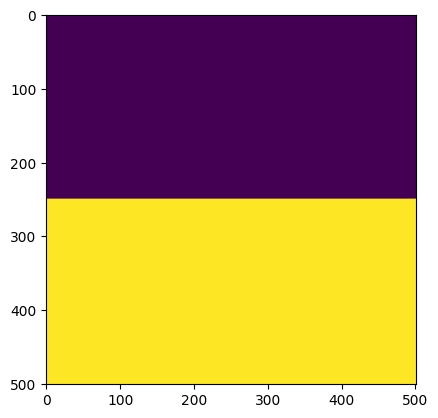

In [45]:
def v(nx, nz, v1=3000, v2=4000):
    vp = np.zeros([nz,nx])
    vp[0:int(nz/2),:]= v1
    vp[int(nz/2):nz,:] = v2
    return vp

c = v(nx,nz)

plt.figure()
plt.imshow(c,aspect='equal')
plt.show()


3. Modelagem sísmica

3.1 Método das diferenças finitas

A solução da equação da onda de forma discreta num grid com dx e dz foram obtidas a partir da expansão em série de Taylor com operadores de oitava ordem para a solução das segundas derivadas no tempo e espaço. Substituindo as segundas derivadas na equação da onda é possível obter o campo de pressão num instante posterior t+1 a partir do campo nos instantes t e t-1. Repetindo esse processo num loop podemos determinar a propagação da onda em cada instante do tempo.

3.2 Condição de estabilidade e dispersão numérica

A estabilidade numérica do modelo pode ser definida pelo critério de Courant-Friedrich-Levy.

dt_lim = dx_lim / (4 * vp_max)

A condição para não-dispersão numérica é

dx_lim = lambda_min / 5

3.3 Fronteiras absorventes

Temos que tomar cuidado com as reflexões indesejadas ocorridas nas bordas do modelo devido à propagação do campo de pressão. Essas reflexões
podem ser erroneamente consideradas como reflexões válidas. Para eliminar tais reflexões cria-se uma atenuação nas bordas laterais e nas bordas superior e inferior com a multiplicação do campo de pressão por uma função atenuante “A”. No caso em questão usaremos a função proposta no trabalho de (CERJAN, 1985), a qual consiste em criar uma zona de amortecimento numérico onde a amplitude da onda é reduzida gradualmente a zero. Essa expressão é dada por:

Borda de atenuação

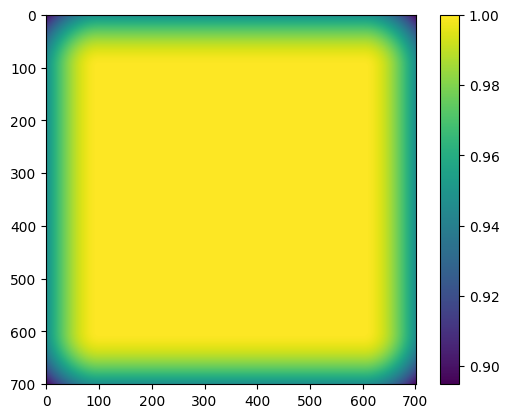

In [46]:
def borda (nx,nz,fator, N):
    A = np.ones((nz, nx))
    sb = 3*N 
    for i in range(nx):
        for j in range(nz):
            if i < N:  
                fb = (N - i) / (np.sqrt(2) * sb)
                A[j, i] *= np.exp(-fb * fb)
            elif i >= nx - N: 
                fb = (i - (nx - N)) / (np.sqrt(2) * sb)
                A[j, i] *= np.exp(-fb * fb)
            if j < N:  
                fb = (N - j) / (np.sqrt(2) * sb)
                A[j, i] *= np.exp(-fb * fb)
            elif j >= nz - N:  
                fb = (j - (nz - N)) / (np.sqrt(2) * sb)
                A[j, i] *= np.exp(-fb * fb)
    return A

A = borda(nx_abc, nz_abc, 0.015, N)
plt.imshow(A, cmap="viridis", origin="upper")
plt.colorbar()
plt.show()

Método das diferenças finitas de quarta ordem

In [47]:
# @numba.jit(parallel=True, nopython=True)
# def marcha_no_espaço(u_anterior, u, u_posterior, nx, nz, c, dt, dx, dz):
#     for i in numba.prange(2, nx - 3):
#         for j in numba.prange(2, nz - 3):
#             pxx = (-u[j, i+2] + 16*u[j, i+1] - 30*u[j, i] + 16*u[j, i-1] - u[j, i-2]) / (12 * dx * dx)
#             pzz = (-u[j+2, i] + 16*u[j+1, i] - 30*u[j, i] + 16*u[j-1, i] - u[j-2, i]) / (12 * dz * dz)
#             u_posterior[j, i] = (c[j, i] ** 2) * (dt ** 2) * (pxx + pzz) + 2 * u[j, i] - u_anterior[j, i]
#     return u_posterior

Método das diferenças finitas de oitava ordem

In [48]:
@numba.jit(parallel=True, nopython=True)
def marcha_no_espaço(u_anterior, u, u_posterior, nx, nz, c, dt, dx, dz):
    c0 = -205 / 72
    c1 = 8 / 5
    c2 = -1 / 5
    c3 = 8 / 315
    c4 = -1 / 560
    for i in numba.prange(4, nx - 4):  
        for j in numba.prange(4, nz - 4):  
            pxx = (c0 * u[j, i] + c1 * (u[j, i+1] + u[j, i-1]) + c2 * (u[j, i+2] + u[j, i-2]) +c3 * (u[j, i+3] + u[j, i-3]) +c4 * (u[j, i+4] + u[j, i-4])) / (dx * dx)
            pzz = (c0 * u[j, i] + c1 * (u[j+1, i] + u[j-1, i]) + c2 * (u[j+2, i] + u[j-2, i]) + c3 * (u[j+3, i] + u[j-3, i]) + c4 * (u[j+4, i] + u[j-4, i])) / (dz * dz)
            u_posterior[j, i] = (c[j, i] ** 2) * (dt ** 2) * (pxx + pzz) + 2 * u[j, i] - u_anterior[j, i]
    return u_posterior

Marcha no tempo 

In [49]:

def marcha_no_tempo(u_anterior, u, u_posterior, source, nt, nx, nz, c, recx, recz, dt, A, shot_x, shot_z, dx, dz, frame ):
    sism_shot = []
    u_snapshot = []
    for i_shot, (sx, sz) in enumerate(zip(shot_x, shot_z)):
        u_anterior.fill(0)  
        u.fill(0)
        u_posterior.fill(0)
        sism = np.zeros((nt, len(recx)))
        for k in range(nt):
            u[sz,sx]= u[sz,sx] + source[k]
            u_posterior = marcha_no_espaço(u_anterior, u, u_posterior, nx, nz, c, dt, dx, dz) 
            u_posterior *= A
            u_anterior = np.copy(u)
            u_anterior *= A 
            u = np.copy(u_posterior)

            sism[k, :] = u[recz, recx]
            if k == frame:
                u_snapshot.append(u.copy())

        sism_shot.append(sism)
    return sism_shot , u_snapshot

Expansão do modelo de velocidade devido a borda de atenuação

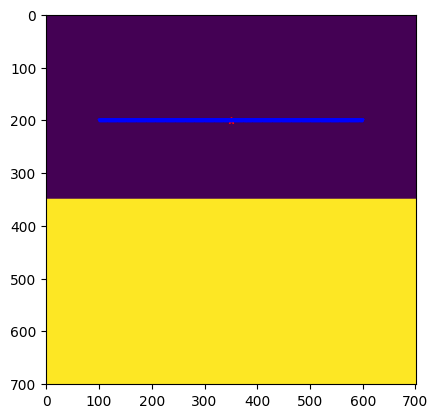

In [50]:
def expand_vp(v,nx_abc,nz_abc, N):
    v_expand = np.zeros((nz_abc, nx_abc))
    v_expand[N:nz_abc-N, N:nx_abc - N] = v
    v_expand[0:N,N: nx_abc - N]= v[0, :]
    v_expand[nz_abc - N : nz_abc, N: nx_abc - N]= v[-1, :]
    v_expand[N:nz_abc-N, 0:N] = v[:, 0][:, np.newaxis]
    v_expand[N:nz_abc-N, nx_abc-N:nx_abc] = v[:, -1][:, np.newaxis]
    v_expand[0:N, 0:N] = v[0, 0]  
    v_expand[0:N, nx_abc-N:nx_abc] = v[0, -1] 
    v_expand[nz_abc-N:nz_abc, 0:N] = v[-1, 0]  
    v_expand[nz_abc-N:nz_abc, nx_abc-N:nx_abc] = v[-1, -1]
    return v_expand

c = v(nx,nz)
c_expand= expand_vp(c,nx_abc,nz_abc, N)


plt.figure()
plt.plot(shot_x,shot_z,"r*", markersize=5)
plt.plot(rec_x,rec_z,'bv',markersize = 2)
plt.imshow(c_expand,aspect='equal')
plt.show()


Critérios de dispersão e estabilidade

In [51]:
#critérios de dispersão e estabilidade
vp_min= np.min(c_expand)
vp_max = np.max(c_expand)
lambda_min = vp_min / f0
dx_lim = lambda_min / 5
dt_lim = dx_lim / (4 * vp_max)
if (dt<=dt_lim and dx<=dx_lim):
    print("Condições de estabilidade e dispersão satisfeitas")
else:
    print("Condições de estabilidade e dispersão não satisfeitas")
    print("dt_critical = %f dt = %f" %(dt_lim,dt))
    print("dx_critical = %f dx = %f" %(dx_lim,dx))
    print("fcut = %f " %(f0))

Condições de estabilidade e dispersão satisfeitas


Inicialização das funções

In [52]:
u_anterior, u, u_posterior = ondas(nx_abc,nz_abc)
A = borda(nx_abc, nz_abc, 0.015, N)
frame = 2000
sism_shot, u_snapshot = marcha_no_tempo(u_anterior, u, u_posterior, source, nt, nx_abc, nz_abc, c_expand, rec_x, rec_z, dt, A, shot_x, shot_z, dx, dz,frame)
sism_shot = sism_shot[::-1]
u_snapshot = u_snapshot[::-1]


Função que plota o sismograma por shot e salva em disco

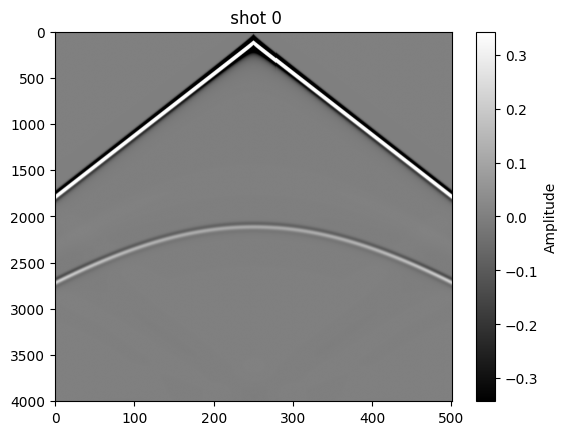

In [53]:
def plot_shot(sism_shot):
    for i in range(len(sism_shot)):
        perc = np.percentile(sism_shot[i], 99)
        plt.imshow(sism_shot[i], aspect='auto', cmap='gray', vmin=-perc, vmax=perc)
        plt.colorbar(label='Amplitude')
        plt.title(" shot %s"%i)
        plt.show()
    # for i, shot in enumerate(sism_shot):
    #     filename = f'../ModelagemSismica/outputs/seismograms/sismograma_shot_{i}_{shot.shape[0]}x{shot.shape[1]}.bin'
    #     print(filename)
    #     shot.tofile(filename)

plot_shot(sism_shot)

Snapshots

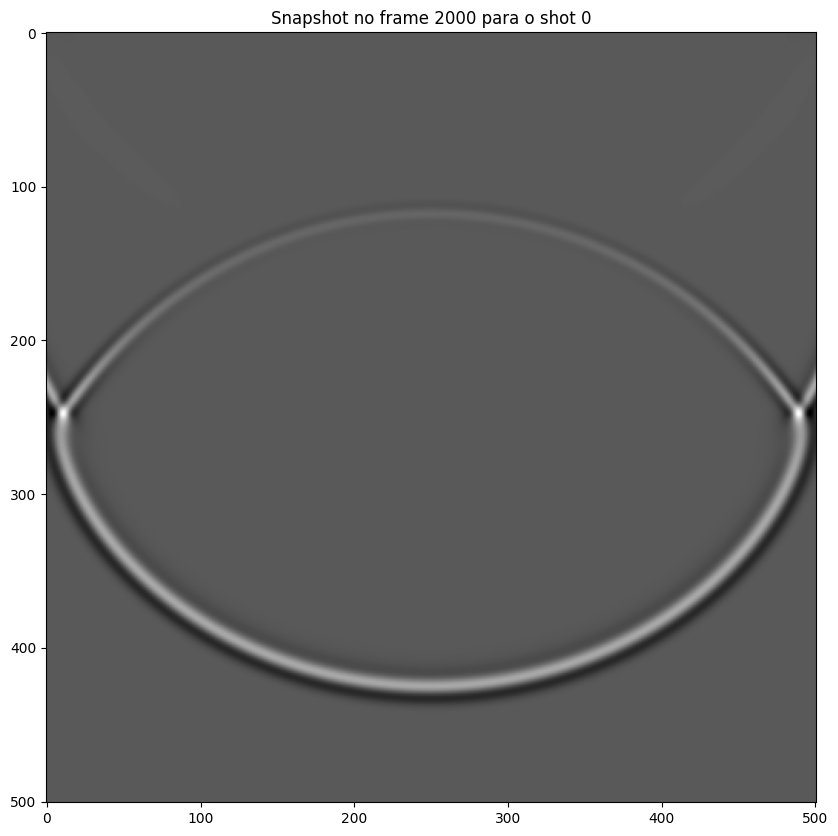

In [54]:
def snapshot(p_snapshot, shot, frame):
    p_cut = p_snapshot[shot][N:-N, N:-N]
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(p_cut, cmap='gray')
    plt.title(f"Snapshot no frame {frame} para o shot {shot}")
    plt.show()
    # filename = f'../ModelagemSismica/outputs/snapshots/snapshot_frame_{frame}_shot_{shot}_nx_{p_cut.shape[1]}_nz_{p_cut.shape[0]}vti.bin'
    # p_cut.astype(np.float32).tofile(filename)
    # print(f"Snapshot do frame {frame} salvo em: {filename}")

snapshot(u_snapshot, 0, frame)

Para o modelo Marmousi, temos

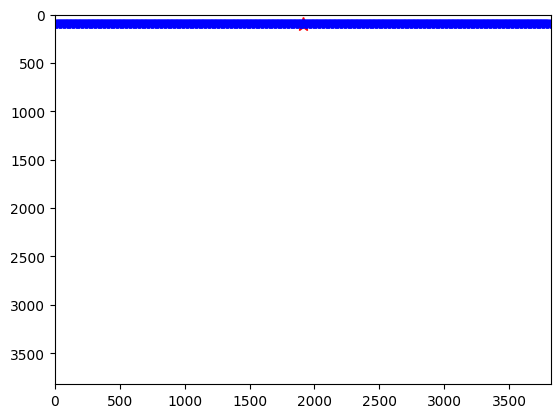

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# sources
sx_init = 1910
sx_end  = 1910
Nsource = 1
sx = np.linspace(sx_init,sx_end,Nsource)
sz = 100*np.ones(len(sx))
sIdx = np.arange(Nsource)

# receivers
rx_init = 0
rx_end = 3821
Nrec = 383
rx = np.linspace(rx_init,rx_end,Nrec,endpoint=False)
rz = 100*np.ones(len(rx))
rIdx = np.arange(Nrec)

plt.figure()
plt.plot(sx,sz,"r*", markersize=10)
plt.plot(rx,rz,'bv')
plt.xlim(0,rx_end)
plt.ylim(rx_end,0)
plt.show()

receiver_df = pd.DataFrame({'index': rIdx,'coordx': rx,'coordz': rz})

source_df = pd.DataFrame({'index': sIdx,'coordx': sx,'coordz': sz})

receiver_df.to_csv("D:/GitHub/ModelagemSismica/inputs/receivers.csv", index=False)
source_df.to_csv("D:/GitHub/ModelagemSismica/inputs/sources.csv", index=False)

Modelo de velocidade carregado de: /GitHub/ModelagemSismica/inputs/marmousi_vp_383x141.bin


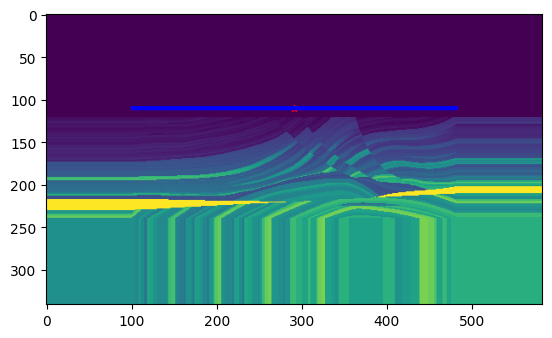

Condições de estabilidade e dispersão satisfeitas


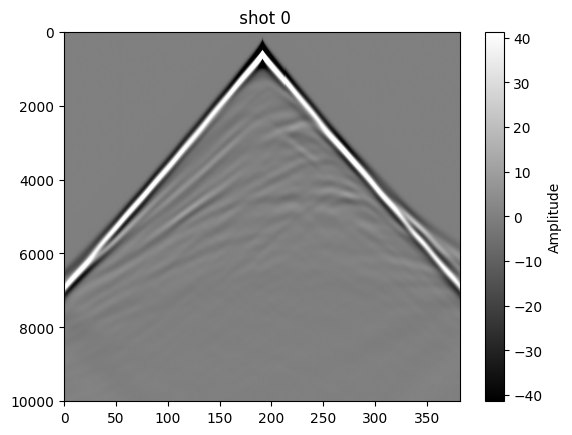

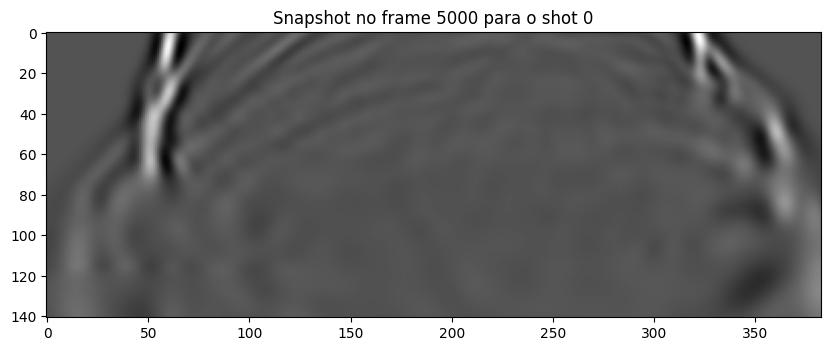

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import jit
import pandas as pd

def ler_modelo(caminho_arquivo, shape):
    vp = np.fromfile(caminho_arquivo, dtype=np.float32)
    vp = vp.reshape(shape).T
    print(f"Modelo de velocidade carregado de: {caminho_arquivo}")
    return vp

def expand_vp(v,nx_abc,nz_abc, N):
    v_expand = np.zeros((nz_abc, nx_abc))
    v_expand[N:nz_abc-N, N:nx_abc-N] = v
    v_expand[0:N, N:nx_abc-N] = v[0, :]
    v_expand[nz_abc-N:nz_abc, N:nx_abc-N] = v[-1, :]
    v_expand[N:nz_abc-N, 0:N] = v[:, 0:1]
    v_expand[N:nz_abc-N, nx_abc-N:nx_abc] = v[:, -1:]
    v_expand[0:N, 0:N] = v[0, 0]
    v_expand[0:N, nx_abc-N:nx_abc] = v[0, -1]
    v_expand[nz_abc-N:nz_abc, 0:N] = v[-1, 0]
    v_expand[nz_abc-N:nz_abc, nx_abc-N:nx_abc] = v[-1, -1]
    return v_expand


def ricker(f0, t):
    pi = np.pi
    td  = t - 2 * np.sqrt(pi) / f0
    fcd = f0 / (np.sqrt(pi) * 3) 
    source = (1 - 2 * pi * (pi * fcd * td) * (pi * fcd * td)) * np.exp(-pi * (pi * fcd * td) * (pi * fcd * td))
    return source

def ondas(nx,nz):
    u_anterior = np.zeros((nz,nx))
    u = np.zeros((nz,nx))
    u_posterior = np.zeros((nz,nx))
    return u_anterior, u, u_posterior

def borda (nx,nz,fator, N):
    A = np.ones((nz, nx))
    sb = 3*N 
    for i in range(nx):
        for j in range(nz):
            if i < N:  
                fb = (N - i) / (np.sqrt(2) * sb)
                A[j, i] *= np.exp(-fb * fb)
            elif i >= nx - N: 
                fb = (i - (nx - N)) / (np.sqrt(2) * sb)
                A[j, i] *= np.exp(-fb * fb)
            if j < N:  
                fb = (N - j) / (np.sqrt(2) * sb)
                A[j, i] *= np.exp(-fb * fb)
            elif j >= nz - N:  
                fb = (j - (nz - N)) / (np.sqrt(2) * sb)
                A[j, i] *= np.exp(-fb * fb)
    return A

@numba.jit(parallel=True, nopython=True)
def marcha_no_espaço(u_anterior, u, u_posterior, nx, nz, c, dt, dx, dz):
    c0 = -205 / 72
    c1 = 8 / 5
    c2 = -1 / 5
    c3 = 8 / 315
    c4 = -1 / 560
    for i in numba.prange(4, nx - 4):  
        for j in numba.prange(4, nz - 4):  
            pxx = (c0 * u[j, i] + c1 * (u[j, i+1] + u[j, i-1]) + c2 * (u[j, i+2] + u[j, i-2]) +c3 * (u[j, i+3] + u[j, i-3]) +c4 * (u[j, i+4] + u[j, i-4])) / (dx * dx)
            pzz = (c0 * u[j, i] + c1 * (u[j+1, i] + u[j-1, i]) + c2 * (u[j+2, i] + u[j-2, i]) + c3 * (u[j+3, i] + u[j-3, i]) + c4 * (u[j+4, i] + u[j-4, i])) / (dz * dz)
            u_posterior[j, i] = (c[j, i] ** 2) * (dt ** 2) * (pxx + pzz) + 2 * u[j, i] - u_anterior[j, i]
    return u_posterior

def marcha_no_tempo(u_anterior, u, u_posterior, source, nt, nx, nz, c, recx, recz, dt, A, shot_x, shot_z, dx, dz, frame ):
    sism_shot = []
    u_snapshot = []
    for i_shot, (sx, sz) in enumerate(zip(shot_x, shot_z)):
        u_anterior.fill(0)  
        u.fill(0)
        u_posterior.fill(0)
        sism = np.zeros((nt, len(recx)))
        for k in range(nt):
            u[sz,sx]= u[sz,sx] + source[k]
            u_posterior = marcha_no_espaço(u_anterior, u, u_posterior, nx, nz, c, dt, dx, dz) 
            u_posterior *= A
            u_anterior = np.copy(u)
            u_anterior *= A 
            u = np.copy(u_posterior)

            sism[k, :] = u[recz, recx]
            if k == frame:
                u_snapshot.append(u.copy())

        sism_shot.append(sism)
    return sism_shot , u_snapshot
                         
def snapshot(p_snapshot, shot, frame):
    p_cut = p_snapshot[shot][N:-N, N:-N]
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(p_cut, cmap='gray')
    plt.title(f"Snapshot no frame {frame} para o shot {shot}")
    plt.show()
    # filename = f'../ModelagemSismica/outputs/snapshots/snapshot_frame_{frame}_shot_{shot}_nx_{p_cut.shape[1]}_nz_{p_cut.shape[0]}vti.bin'
    # p_cut.astype(np.float32).tofile(filename)
    # print(f"Snapshot do frame {frame} salvo em: {filename}")

                    
def plot_shot(sism_shot):
    for i in range(len(sism_shot)):
        perc = np.percentile(sism_shot[i], 99)
        plt.imshow(sism_shot[i], aspect='auto', cmap='gray', vmin=-perc, vmax=perc)
        plt.colorbar(label='Amplitude')
        plt.title(" shot %s"%i)
        plt.show()
    # for i, shot in enumerate(sism_shot):
    #     filename = f'../ModelagemSismica/outputs/seismograms/sismograma_shot_{i}_{shot.shape[0]}x{shot.shape[1]}.bin'
    #     print(filename)
    #     shot.tofile(filename)

receiverTable = pd.read_csv("/GitHub/ModelagemSismica/inputs/receivers.csv")
sourceTable = pd.read_csv("/GitHub/ModelagemSismica/inputs/sources.csv")
rec_x = receiverTable['coordx'].to_numpy()
rec_z = receiverTable['coordz'].to_numpy()
shot_x = sourceTable['coordx'].to_numpy()
shot_z = sourceTable['coordz'].to_numpy()

T = 2 
dt = 0.0002

L  = 3820
H = 1400
dx = 10
dz = 10
N = 100

nx = int(L/dx) + 1
nz = int(H/dz) + 1
nt = int(T/dt) + 1

nx_abc = nx + 2*N
nz_abc = nz + 2*N

rec_x = np.round(rec_x/dx).astype(int) + N 
rec_z = np.round(rec_z/dz).astype(int) + N
shot_x = np.round(shot_x/dx).astype(int) + N
shot_z = np.round(shot_z/dz).astype(int) + N

t = np.linspace(0, T, nt, endpoint=False)

f0 = 30
source = ricker(f0, t)

c = ler_modelo('/GitHub/ModelagemSismica/inputs/marmousi_vp_383x141.bin', (nx, nz))
c_expand = expand_vp(c,nx_abc,nz_abc, N)

plt.figure()
plt.plot(shot_x,shot_z,"r*", markersize=5)
plt.plot(rec_x,rec_z,'bv',markersize = 2)
plt.imshow(c_expand,aspect='equal')
plt.show()

#critérios de dispersão e estabilidade
vp_min= np.min(c_expand)
vp_max = np.max(c_expand)
lambda_min = vp_min / f0
dx_lim = lambda_min / 5
dt_lim = dx_lim / (4 * vp_max)
if (dt<=dt_lim and dx<=dx_lim):
    print("Condições de estabilidade e dispersão satisfeitas")
else:
    print("Condições de estabilidade e dispersão não satisfeitas")
    print("dt_critical = %f dt = %f" %(dt_lim,dt))
    print("dx_critical = %f dx = %f" %(dx_lim,dx))
    print("fcut = %f " %(f0))

u_anterior, u, u_posterior = ondas(nx_abc,nz_abc)
A = borda(nx_abc, nz_abc, 0.015, N)
frame = 5000
sism_shot, u_snapshot = marcha_no_tempo(u_anterior, u, u_posterior, source, nt, nx_abc, nz_abc, c_expand, rec_x, rec_z, dt, A, shot_x, shot_z, dx, dz,frame)
sism_shot = sism_shot[::-1]
u_snapshot = u_snapshot[::-1]
plot_shot(sism_shot)
snapshot(u_snapshot, 0, frame)




4. Validação do Modelo Computacional com o Modelo Analítico

Código de tempo de trânsito e sismograma analítico

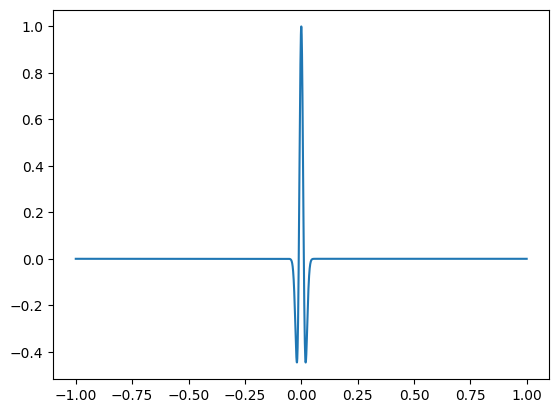

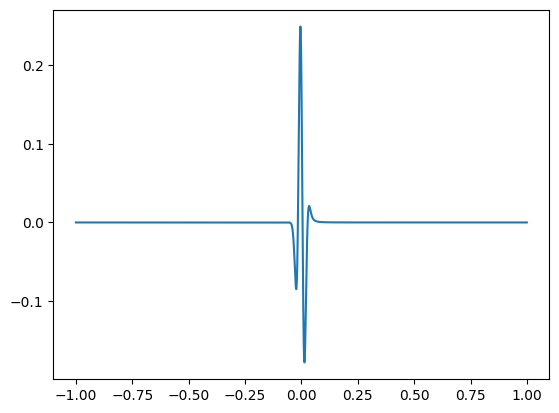

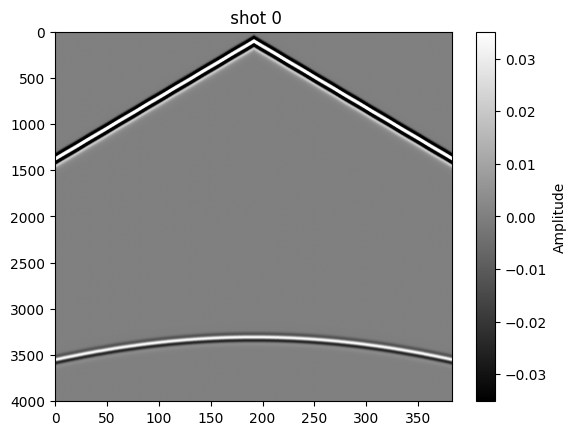

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def ricker(f0, td):
    pi = np.pi
    # td  = t - 2 * np.sqrt(pi) / f0
    fcd = f0 / (np.sqrt(pi) * 3) 
    source = (1 - 2 * pi * (pi * fcd * td) * (pi * fcd * td)) * np.exp(-pi * (pi * fcd * td) * (pi * fcd * td))
    return source

def half_derivative(sinal):
    fwavelet = np.fft.fft(sinal)
    omega = 2*np.pi*np.fft.fftfreq(len(sinal))
    fwavelet_half = np.sqrt(1j*omega)*fwavelet
    wavelet_half = np.real(np.fft.ifft(fwavelet_half))
    return wavelet_half
    

receiverTable = pd.read_csv('D:/GitHub/ModelagemSismica/inputs/receivers.csv')
sourceTable = pd.read_csv('D:/GitHub/ModelagemSismica/inputs/sources.csv')

rec_x = receiverTable['coordx'].to_numpy()
rec_z = receiverTable['coordz'].to_numpy()
shot_x = sourceTable['coordx'].to_numpy()
shot_z = sourceTable['coordz'].to_numpy()

L = 5000        
H = 5000          
T = 2            
dt = 0.0005        
dx = dz = 10      
f0 = 60
           
nx = int(L/dx) + 1
nz = int(H/dz) + 1
nt = int(T/dt) + 1

x = np.linspace(0, L, nx, endpoint=False)
z = np.linspace(0, H, nz, endpoint=False)
t = np.linspace(-T/2, T/2, nt, endpoint=False) 


v1=3000
v2=4000

R1 = (v2 - v1)/ (v2 + v1)

td = 0 #2 * np.sqrt(np.pi) / f0
wavelet = ricker(f0, t-td)
plt.figure()
plt.plot(t, wavelet) 
plt.show()
wavelet_half = half_derivative(wavelet)
plt.figure()    
plt.plot(t, wavelet_half)
plt.show()

h1 = H/2 - shot_z[0]

t_direct = np.zeros((len(shot_x), len(rec_x)))
t_ref1 = np.zeros((len(shot_x), len(rec_x)))

sism_shot = []
t_lag = 2 * np.sqrt(np.pi) / f0
for i in range(len(shot_x)):
    sism = np.zeros((nt, len(rec_x)))
    for j in range(len(rec_x)):
        dist = np.sqrt((shot_x[i] - rec_x[j]) ** 2 + (shot_z[i] - rec_z[j]) ** 2)
        t_direct[i, j] = dist / v1 + t_lag
        t_ref1[i, j] = np.sqrt(dist**2 + (2*h1)**2) / v1 + t_lag

        if (t_direct[i, j] < T):
            sism[int(t_direct[i, j]/dt), j] = 1
        if (t_ref1[i, j] < T):
            sism[int(t_ref1[i, j]/dt), j] = R1

        sism[:,j] = np.convolve(sism[:,j], wavelet_half, mode='same')
    sism_shot.append(sism.copy())   

for i in range(len(sism_shot)):
    perc = np.percentile(sism_shot[i], 99)
    plt.imshow(sism_shot[i], aspect='auto', cmap='gray', vmin=-perc, vmax=perc)
    plt.colorbar(label='Amplitude')
    plt.title(" shot %s"%i)
    plt.show()
# for i, shot in enumerate(sism_shot):
#     shot.tofile(f'../ModelagemSismica/outputs/seismograms/sismograma_analitico_shot_{i}_{shot.shape[0]}x{shot.shape[1]}.bin')




Modelagem analítica x Modelagem acústica

Sismograma carregado de: D:/GitHub/ModelagemSismica/outputs/seismograms/sismograma_analitico_shot_0_4001x501.bin
Sismograma carregado de: D:/GitHub/ModelagemSismica/outputs/seismograms/sismograma_shot_0_4001x501.bin


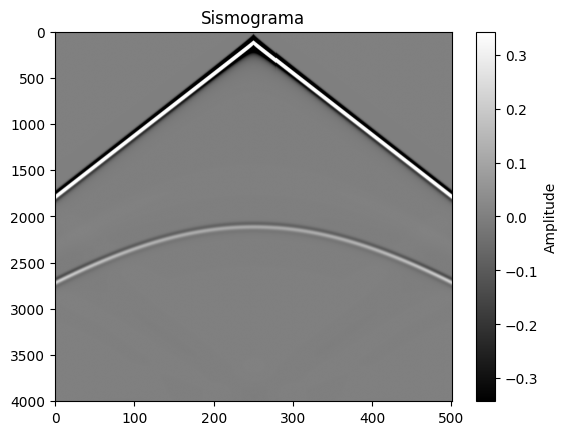

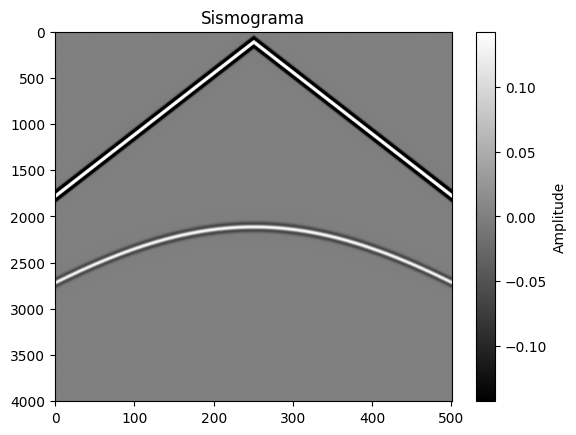

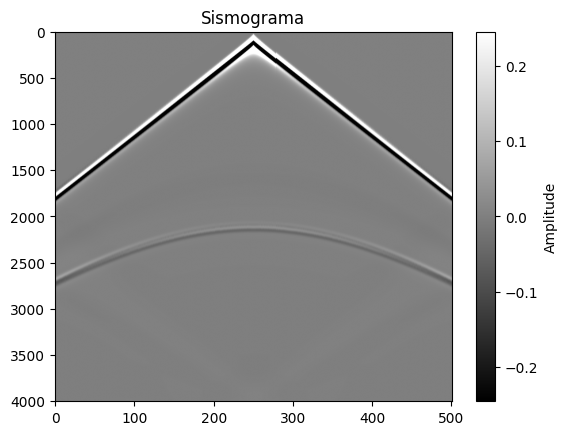

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import jit
import pandas as pd

def ler_sismograma(caminho_arquivo, shape):
    sism = np.fromfile(caminho_arquivo, dtype=np.float64)  
    sism = sism.reshape(shape)
    print(f"Sismograma carregado de: {caminho_arquivo}")
    return sism

def plot_sismograma(sism):
    plt.figure()
    perc = np.percentile(sism,99)
    plt.imshow(sism,aspect='auto',cmap='gray',vmin=-perc,vmax=perc)
    plt.colorbar(label='Amplitude')
    plt.title("Sismograma")
    plt.show(block = False)

sism_analitico = ler_sismograma('D:/GitHub/ModelagemSismica/outputs/seismograms/sismograma_analitico_shot_0_4001x501.bin', (4001, 501))
sism = ler_sismograma('D:/GitHub/ModelagemSismica/outputs/seismograms/sismograma_shot_0_4001x501.bin', (4001, 501))
plot_sismograma(sism)
plot_sismograma(sism_analitico)
sism_residual = sism_analitico - sism
plot_sismograma(sism_residual)

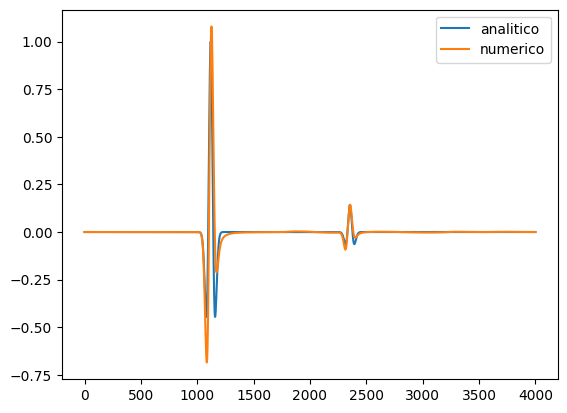

In [59]:
plt.figure()
plt.plot(sism_analitico[:,100], label='analitico')
plt.plot(sism[:,100], label='numerico')
plt.legend()
plt.show()

Modelo pseudoacustico VTI

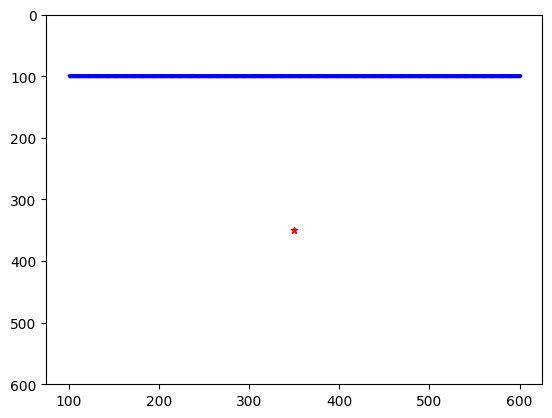

Condições de estabilidade e dispersão satisfeitas


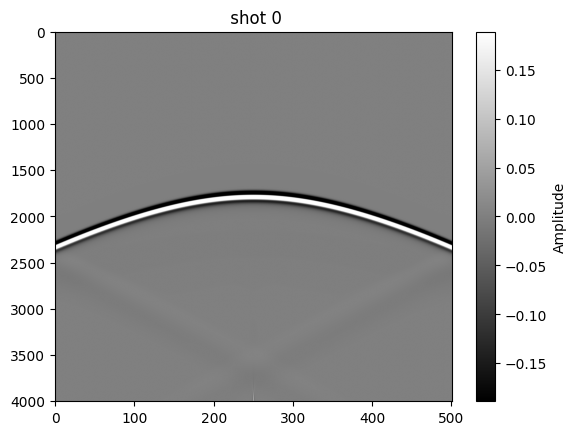

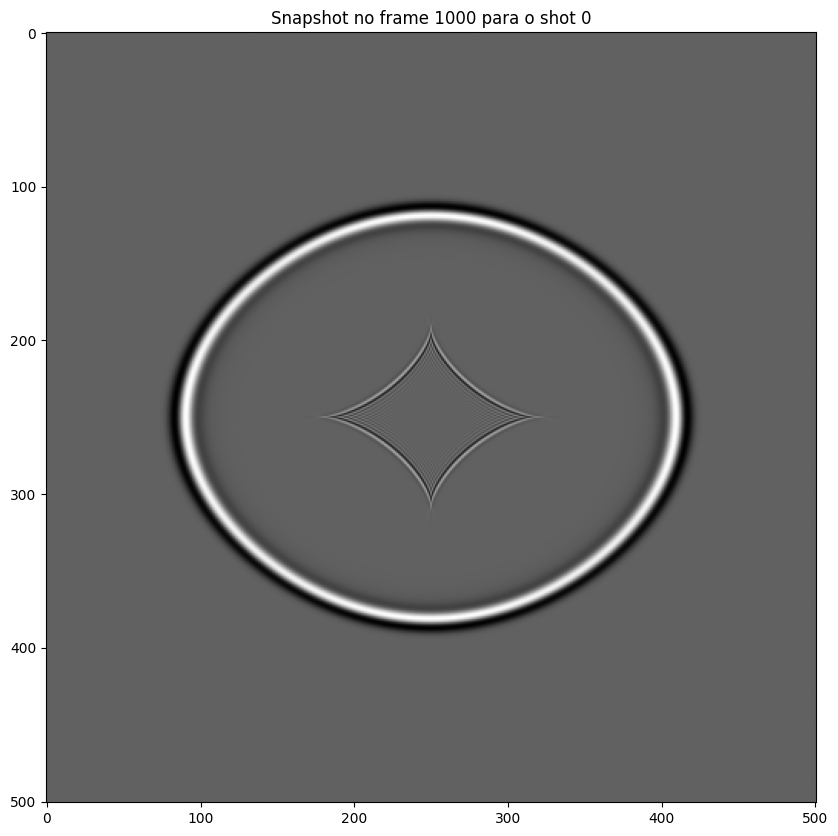

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import jit
import pandas as pd


def ricker(f0, t):
    pi = np.pi
    td  = t - 2 * np.sqrt(pi) / f0
    fcd = f0 / (np.sqrt(pi) * 3) 
    source = (1 - 2 * pi * (pi * fcd * td) * (pi * fcd * td)) * np.exp(-pi * (pi * fcd * td) * (pi * fcd * td))
    return source

def ondas(nx,nz):
    p_anterior = np.zeros((nz,nx))
    p = np.zeros((nz,nx))
    p_posterior = np.zeros((nz,nx))
    q_anterior = np.zeros((nz,nx))
    q = np.zeros((nz,nx))
    q_posterior = np.zeros((nz,nx))
    return p_anterior, p, p_posterior, q_anterior, q, q_posterior

def borda (nx,nz,fator, N):
    A = np.ones((nz, nx))
    sb = 3*N 
    for i in range(nx):
        for j in range(nz):
            if i < N:  
                fb = (N - i) / (np.sqrt(2) * sb)
                A[j, i] *= np.exp(-fb * fb)
            elif i >= nx - N: 
                fb = (i - (nx - N)) / (np.sqrt(2) * sb)
                A[j, i] *= np.exp(-fb * fb)
            if j < N:  
                fb = (N - j) / (np.sqrt(2) * sb)
                A[j, i] *= np.exp(-fb * fb)
            elif j >= nz - N:  
                fb = (j - (nz - N)) / (np.sqrt(2) * sb)
                A[j, i] *= np.exp(-fb * fb)
    return A


@numba.jit(parallel=True, nopython=True)
def marcha_no_espaço(p_anterior, p, p_posterior, q, q_anterior, q_posterior, nx, nz, dt, dx, dz, vpz, epsilon, delta):
    cx = vpz**2 * (1 + 2 * epsilon)
    bx = vpz**2 * (1 + 2 * delta)
    cz = bz = vpz**2    
    c0 = -205 / 72
    c1 = 8 / 5
    c2 = -1 / 5
    c3 = 8 / 315
    c4 = -1 / 560
    for i in numba.prange(4, nx - 4):  
        for j in numba.prange(4, nz - 4):  
            pxx = (c0 * p[j, i] + c1 * (p[j, i+1] + p[j, i-1]) + c2 * (p[j, i+2] + p[j, i-2]) + 
                   c3 * (p[j, i+3] + p[j, i-3]) + c4 * (p[j, i+4] + p[j, i-4])) / (dx * dx)
            qzz = (c0 * q[j, i] + c1 * (q[j+1, i] + q[j-1, i]) + c2 * (q[j+2, i] + q[j-2, i]) + 
                   c3 * (q[j+3, i] + q[j-3, i]) + c4 * (q[j+4, i] + q[j-4, i])) / (dz * dz)
            p_posterior[j, i] = 2 * p[j, i] - p_anterior[j, i] + (dt**2) * (cx * pxx  + cz * qzz)
            q_posterior[j, i] = 2 * q[j, i] - q_anterior[j, i] + (dt**2) * (bx * pxx  + bz * qzz)

    return p_posterior, q_posterior


def marcha_no_tempo(p_anterior, p, p_posterior, q, q_anterior, q_posterior, source, nt, nx, nz, recx, recz, dt, A, shot_x, shot_z, dx, dz, frame, vpz, epsilon, delta):
    sism_shot = []
    p_snapshot = []
    for i_shot, (sx, sz) in enumerate(zip(shot_x, shot_z)):
        p_anterior.fill(0)  
        p.fill(0)
        p_posterior.fill(0)
        q_anterior.fill(0)  
        q.fill(0)
        q_posterior.fill(0)
        sism = np.zeros((nt, len(recx)))
        for k in range(nt):
            p[sz,sx]= p[sz,sx] + source[k]
            q[sz,sx]= q[sz,sx] + source[k]
            p_posterior, q_posterior = marcha_no_espaço(p_anterior, p, p_posterior, q, q_anterior, q_posterior, nx, nz, dt, dx, dz, vpz, epsilon, delta)
            p_posterior *= A
            q_posterior *= A
            p_anterior = np.copy(p) 
            q_anterior = np.copy(q)
            p_anterior *= A
            q_anterior *= A
            p = np.copy(p_posterior)
            q = np.copy(q_posterior)

            sism[k, :] = p[recz, recx]
            if k == frame:
                p_snapshot.append(p.copy())

        sism_shot.append(sism)
    return sism_shot,p_snapshot


def snapshot(p_snapshot, shot, frame):
    p_cut = p_snapshot[shot][N:-N, N:-N]
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(p_cut, cmap='gray')
    plt.title(f"Snapshot no frame {frame} para o shot {shot}")
    plt.show()
    # filename = f'../ModelagemSismica/outputs/snapshots/snapshot_frame_{frame}_shot_{shot}_nx_{p_cut.shape[1]}_nz_{p_cut.shape[0]}vti.bin'
    # p_cut.astype(np.float32).tofile(filename)
    # print(f"Snapshot do frame {frame} salvo em: {filename}")

                    
def plot_shot(sism_shot):
    for i in range(len(sism_shot)):
        perc = np.percentile(sism_shot[i], 99)
        plt.imshow(sism_shot[i], aspect='auto', cmap='gray', vmin=-perc, vmax=perc)
        plt.colorbar(label='Amplitude')
        plt.title(" shot %s"%i)
        plt.show()
    # for i, shot in enumerate(sism_shot):
    #     filename = f'../outputs/seismograms/sismograma_shot_{i}_{shot.shape[0]}x{shot.shape[1]}.bin'
    #     print(filename)
    #     shot.tofile(filename)


T = 2 
dt = 0.0005

L = 5000
H = 5000
dx = 10
dz = 10
N = 100

nx = int(L/dx) + 1
nz = int(H/dz) + 1
nt = int(T/dt) + 1

nx_abc = nx + 2*N
nz_abc = nz + 2*N

rec_x = np.arange(N, nx_abc-N, 1).astype(int)
rec_z = 100*np.ones(len(rec_x)).astype(int)
shot_x = [nx_abc // 2]
shot_z = [nx_abc // 2] 

plt.figure()
plt.plot(shot_x,shot_z,"r*", markersize=5)
plt.plot(rec_x,rec_z,'bv',markersize = 2)
plt.ylim(rec_x[-1],0)
plt.show()

vpz = 3000     
epsilon = 0.24 
delta = 0.1

t = np.linspace(0, T, nt, endpoint=False)

f0 = 60
source = ricker(f0, t)

#critérios de dispersão e estabilidade
vp_min = np.min(vpz)
vpx = vpz*np.sqrt(1+2*epsilon)
vpx_max = np.max(vpx)
lambda_min = vp_min / f0
dx_lim = lambda_min / 5
dt_lim = dx_lim / (4 * vpx_max)
if (dt<=dt_lim and dx<=dx_lim):
    print("Condições de estabilidade e dispersão satisfeitas")
else:
    print("Condições de estabilidade e dispersão não satisfeitas")
    print("dt_critical = %f dt = %f" %(dt_lim,dt))
    print("dx_critical = %f dx = %f" %(dx_lim,dx))
    print("fcut = %f " %(f0))

p_anterior, p, p_posterior, q_anterior, q, q_posterior= ondas(nx_abc,nz_abc)
A = borda(nx_abc, nz_abc, 0.015, N)
frame = 1000
sism_shot, p_snapshot = marcha_no_tempo(p_anterior, p, p_posterior, q, q_anterior, q_posterior, source, nt, nx_abc, nz_abc, rec_x, rec_z, dt, A, shot_x, shot_z, dx, dz, frame, vpz, epsilon, delta)
sism_shot = sism_shot[::-1]
p_snapshot = p_snapshot[::-1]
plot_shot(sism_shot)
snapshot(p_snapshot, 0, frame)

Validação do modelo pseudoacústico VTI com os modelos analíticos de anisotropia elíptica e fraca

Sismograma carregado de: D:/GitHub/ModelagemSismica/outputs/snapshots/snapshot_frame_1000_shot_0_nx_501_nz_501vti.bin


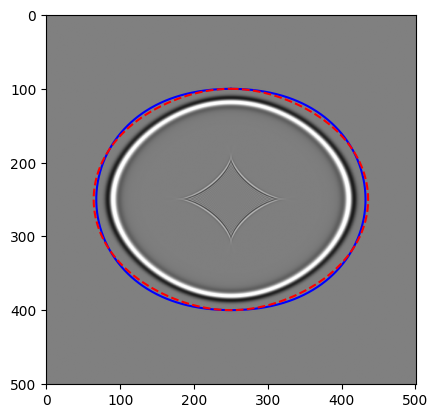

In [61]:
import numpy as np
import matplotlib.pyplot as plt

def ler_sismograma(caminho_arquivo, shape):
    sism = np.fromfile(caminho_arquivo, dtype=np.float32)  
    sism = sism.reshape(shape)
    print(f"Sismograma carregado de: {caminho_arquivo}")
    return sism

def plot_sismograma(sism):
    plt.figure()
    perc = np.percentile(sism,99)
    plt.imshow(sism,aspect='auto',cmap='gray',vmin=-perc,vmax=perc)
    plt.colorbar(label='Amplitude')
    plt.title("Sismograma")
    plt.show(block = False)

snapshot = ler_sismograma('D:/GitHub/ModelagemSismica/outputs/snapshots/snapshot_frame_1000_shot_0_nx_501_nz_501vti.bin', (501, 501))
# plot_sismograma(snapshot)

delta = 0.1
epsilon = 0.24
vpz = 3000
dx = dz = 10      
dt = 0.0005         
tempo_snapshot = 0.5
theta = np.linspace(0, 2*np.pi, 1000)
fonte_x, fonte_z = 250, 250  

vp_elip = vpz * np.sqrt(1 + 2 * epsilon * (np.sin(theta)**2)) 
vp_frac = vpz * (1 + delta * (np.sin(theta)**2) * (np.cos(theta)**2) + epsilon * (np.sin(theta)**4)) 

scale_pixels = 1 / dx  
raio_elip = vp_elip * tempo_snapshot * scale_pixels
raio_frac = vp_frac * tempo_snapshot * scale_pixels

x_elip = fonte_x + raio_elip * np.sin(theta)
z_elip = fonte_z - raio_elip * np.cos(theta)  
x_frac = fonte_x + raio_frac * np.sin(theta)
z_frac = fonte_z - raio_frac * np.cos(theta)

fig,ax = plt.subplots()
perc = np.percentile(snapshot,99)
ax.imshow(snapshot, cmap='gray', vmin=-perc, vmax=perc)
plt.grid(False)
plt.plot(x_elip, z_elip,'b-', label='Vp_elip')
plt.plot(x_frac, z_frac,'r--', label='Vp_frac')

plt.show()